# Import Packages


In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from pandas import concat
import numpy as np
from keras.layers import Dense, Activation, Dropout
from keras.layers import LSTM
from keras.layers import SimpleRNN
from keras.models import Sequential
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_squared_error
from math import sqrt

# Load Data dan Preprocessing

In [ ]:
# @title Load file
from google.colab import files
uploaded = files.upload()

Saving 20240314120826.xlsx to 20240314120826 (2).xlsx


In [ ]:
# @title Preprocessing
def load_data(file):
  df = pd.read_excel(file,
                     usecols=["Tahun", "SGD"])
  df['Tanggal'] = 0
  tempTahun = 0
  month_to_number = {"Januari": "1", "Februari": "2", "Maret": "3", "April": "4", "Mei": "5", "Juni": "6",
                     "Juli": "7", "Agustus": "8", "September": "9",  "Oktober": "10", "November": "11", "Desember": "12"}
  for i in range(len(df)):
    if isinstance(df.loc[i, 'Tahun'], int):
      tempTahun = df.loc[i, 'Tahun']
    else:
      df.loc[i, 'Tanggal'] = str(tempTahun) + '-' + month_to_number[df.loc[i, 'Tahun']] + '-01'

  df['SGD'] = df['SGD'].str.replace(',', '').astype(float)
  df = df.set_index('Tanggal')
  df.index = pd.to_datetime(df.index)

  df = df.drop(columns=['Tahun'])
  df = df.drop(index=df.index[0])
  return df

df = load_data('20240314120826.xlsx')
print(df)

                 SGD
Tanggal             
2024-01-01  11796.00
2023-12-01  11711.64
2023-11-01  11554.33
2023-10-01  11635.79
2023-09-01  11334.00
...              ...
2001-05-01   6114.47
2001-04-01   6421.90
2001-03-01   5778.91
2001-02-01   5646.79
2001-01-01   5416.10

[277 rows x 1 columns]


In [ ]:
# @title Cek index apakah sudah benar
df.index

DatetimeIndex(['2024-01-01', '2023-12-01', '2023-11-01', '2023-10-01',
               '2023-09-01', '2023-08-01', '2023-07-01', '2023-06-01',
               '2023-05-01', '2023-04-01',
               ...
               '2001-10-01', '2001-09-01', '2001-08-01', '2001-07-01',
               '2001-06-01', '2001-05-01', '2001-04-01', '2001-03-01',
               '2001-02-01', '2001-01-01'],
              dtype='datetime64[ns]', name='Tanggal', length=277, freq=None)

# Normalisasi Data

In [ ]:
# @title Konversi time series ke dalam bentuk sequence
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
  n_vars = 1 if type(data) is list else data.shape[1]
  df = pd.DataFrame(data)
  cols, names = list(), list()

## input sequence (t-n, ... t-1)
  for i in range(n_in, 0, -1):
    cols.append(df.shift(i))
    names += [('var%d(t-%d)' % (j + 1, i)) for j in range(n_vars)]

## forecast sequence (t, t+1, ... t+n)
  for i in range(0, n_out):
    cols.append(df.shift(-i))
    if i == 0:
      names += [('var%d(t)' % (j + 1)) for j in range(n_vars)]
    else:
      names += [('var%d(t+%d)' % (j + 1, i)) for j in range(n_vars)]

## put it all together
  agg = concat(cols, axis=1)
  agg.columns = names

## drop rows with NaN values
  if dropnan:
    agg.dropna(inplace=True)
  return agg

In [ ]:
# @title Normalisasi data dalam range 0-1
def normalize_data(data):
 scaler = MinMaxScaler(feature_range=(0, 1))
 data_scaled = scaler.fit_transform(data)
 return scaler, data_scaled

In [ ]:
# @title Inverse data ke range semula
def inverse_normdata(scaler, dataX, yhat):
 dataX = dataX.reshape((dataX.shape[0], dataX.shape[2]))
 inv_y = np.concatenate((dataX, yhat), axis=1)
 inv_y = scaler.inverse_transform(inv_y)
 inv_y = inv_y[:, -1]
 return inv_y

# Build Model

In [ ]:
# @title Build model RNN
def build_model_rnn(train_X):
  model_rnn = Sequential()
  model_rnn.add(SimpleRNN(100,
  input_shape=(train_X.shape[2], train_X.shape[1]),
  return_sequences=True))
  model_rnn.add(Dropout(0.3))
  model_rnn.add(SimpleRNN(128,
  return_sequences=True))
  model_rnn.add(Dropout(0.2))
  model_rnn.add(SimpleRNN(64,
  return_sequences=False))
  model_rnn.add(Dropout(0.2))
  model_rnn.add(Dense(1))
  model_rnn.add(Activation("relu"))
  model_rnn.compile(loss="mse", optimizer="adam")
  return model_rnn

In [ ]:
# @title Build model LSTM
def build_model_lstm(train_X):
  model_lstm = Sequential()
  model_lstm.add(LSTM(100,
  input_shape=(train_X.shape[2], train_X.shape[1]),
  return_sequences=True))
  model_lstm.add(Dropout(0.3))
  model_lstm.add(LSTM(128,
  return_sequences=True))
  model_lstm.add(Dropout(0.2))
  model_lstm.add(LSTM(64,
  return_sequences=False))
  model_lstm.add(Dropout(0.2))
  model_lstm.add(Dense(1))
  model_lstm.add(Activation("relu"))
  model_lstm.compile(loss="mse", optimizer="adam")
  return model_lstm

# Main

In [ ]:
if __name__=='__main__':
 df = load_data("20240314120826.xlsx")

 # reframe data menjadi supervised
 data_reframed = series_to_supervised(df, 1, 1)
 df_data_reframed = pd.DataFrame(data_reframed)

 # scale data menjadi range 0-1
 scaler, data_scaled = normalize_data(data_reframed.values)
 df_data_scaled = pd.DataFrame(data_scaled, index=df_data_reframed.index,
columns=df_data_reframed.columns)

 # drop index dengan tahun 2024 karena tidak dipakai untuk training maupun testing
 df_data_scaled = df_data_scaled.drop(df_data_scaled[df_data_scaled.index.year == 2024].index)

splitting dataset

> testing = 12 data teratas (Januari - Desember 2023)


> training = sisanya




In [ ]:
 # @title Splitting dataset
 test = df_data_scaled.iloc[:12]
 train = df_data_scaled.iloc[12:]

 print(test)
 print(train)

            var1(t-1)   var1(t)
Tanggal                        
2023-12-01   1.000000  1.000000
2023-11-01   0.988085  0.977513
2023-10-01   0.965866  0.989158
2023-09-01   0.977371  0.946018
2023-08-01   0.934746  0.936155
2023-07-01   0.925000  0.942158
2023-06-01   0.930932  0.912854
2023-05-01   0.901977  0.905850
2023-04-01   0.895056  0.904849
2023-03-01   0.894068  0.947161
2023-02-01   0.935876  0.943302
2023-01-01   0.932062  0.956453
            var1(t-1)   var1(t)
Tanggal                        
2022-12-01   0.945056  0.992475
2022-11-01   0.980650  0.963866
2022-10-01   0.952381  0.899120
2022-09-01   0.888407  0.835792
2022-08-01   0.825833  0.849077
...               ...       ...
2001-05-01   0.221421  0.199906
2001-04-01   0.197524  0.243852
2001-03-01   0.240946  0.151939
2001-02-01   0.150129  0.133053
2001-01-01   0.131468  0.100077

[264 rows x 2 columns]


In [ ]:
  # @title Cek ukuran dataset untuk training dan testing
  train_X, train_y = train.iloc[:, :-1], train.iloc[:, -1]
  test_X, test_y = test.iloc[:, :-1], test.iloc[:, -1]

  train_X = train_X.values.reshape((train_X.shape[0], 1, train_X.shape[1]))
  test_X = test_X.values.reshape((test_X.shape[0], 1, test_X.shape[1]))

  print(train_X.shape)
  train_y = pd.DataFrame(train_y)
  test_y = pd.DataFrame(test_y)
  print("train_X shape = %s, train_y shape = %s, test_X shape = %s, test_y shape = %s" %
  (train_X.shape, train_y.shape, test_X.shape, test_y.shape))

(264, 1, 1)
train_X shape = (264, 1, 1), train_y shape = (264, 1), test_X shape = (12, 1, 1), test_y shape = (12, 1)


# Hasil

Epoch 1/100
1/1 - 4s - loss: 0.2946 - val_loss: 0.8973 - 4s/epoch - 4s/step
Epoch 2/100
1/1 - 0s - loss: 0.2576 - val_loss: 0.5950 - 48ms/epoch - 48ms/step
Epoch 3/100
1/1 - 0s - loss: 0.1825 - val_loss: 0.2376 - 62ms/epoch - 62ms/step
Epoch 4/100
1/1 - 0s - loss: 0.0805 - val_loss: 0.0346 - 44ms/epoch - 44ms/step
Epoch 5/100
1/1 - 0s - loss: 0.0269 - val_loss: 0.0081 - 61ms/epoch - 61ms/step
Epoch 6/100
1/1 - 0s - loss: 0.0342 - val_loss: 0.0717 - 46ms/epoch - 46ms/step
Epoch 7/100
1/1 - 0s - loss: 0.0780 - val_loss: 0.1014 - 59ms/epoch - 59ms/step
Epoch 8/100
1/1 - 0s - loss: 0.0852 - val_loss: 0.0797 - 50ms/epoch - 50ms/step
Epoch 9/100
1/1 - 0s - loss: 0.0795 - val_loss: 0.0375 - 47ms/epoch - 47ms/step
Epoch 10/100
1/1 - 0s - loss: 0.0567 - val_loss: 0.0067 - 56ms/epoch - 56ms/step
Epoch 11/100
1/1 - 0s - loss: 0.0278 - val_loss: 0.0015 - 48ms/epoch - 48ms/step
Epoch 12/100
1/1 - 0s - loss: 0.0206 - val_loss: 0.0186 - 62ms/epoch - 62ms/step
Epoch 13/100
1/1 - 0s - loss: 0.0187 - va

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


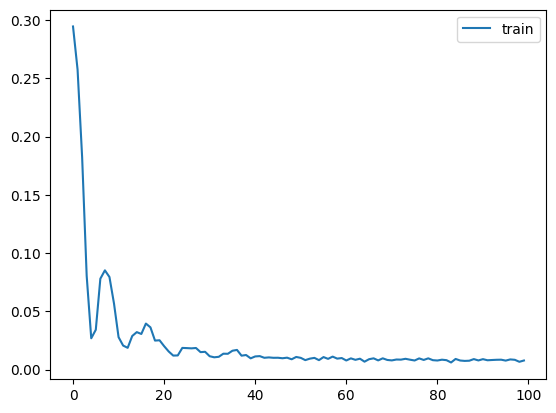

1/1 [==============================] - 0s 43ms/step


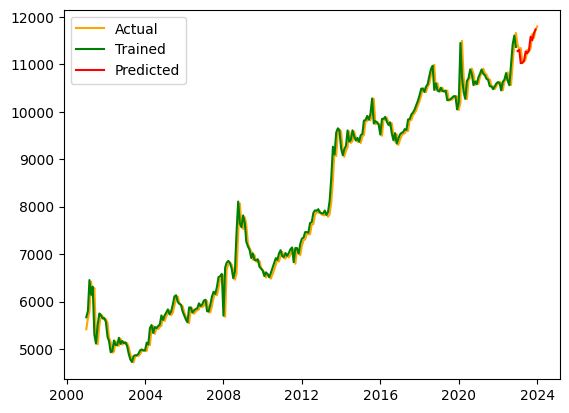

Test RMSE normal : 142.595
Test MSE normal : 20333.378


In [ ]:
  # @title Hasil model RNN
  model_rnn = build_model_rnn(train_X)
  history = model_rnn.fit(train_X, train_y, epochs=100, batch_size=len(train_X), validation_data=(test_X, test_y),
                      verbose=2, shuffle=False)
  model_rnn.save("rnn_model.h5")
  # plot history
  plt.plot(history.history['loss'], label='train')
  plt.legend()
  plt.show()
  # plot model and train data
  y_train = model_rnn.predict(train_X)
  inv_ymodel = inverse_normdata(scaler, train_X, y_train)
  df_inv_ymodel = pd.DataFrame(inv_ymodel, index=train_y.index)
  # plot test data
  y_test = model_rnn.predict(test_X)
  inv_y_test = inverse_normdata(scaler, test_X, y_test)
  df_inv_ytest = pd.DataFrame(inv_y_test, index=test_y.index)
  plt.plot(df, color='orange', label='Actual')
  plt.plot(df_inv_ymodel, color='green', label='Trained')
  plt.plot(df_inv_ytest, color='red', label='Predicted')
  plt.legend()
  plt.show()
  # inverse data dari 0-1 menjadi range awal
  inv_test_y = inverse_normdata(scaler, test_X, test_y)
  rmse_normal = sqrt(mean_squared_error(inv_test_y, inv_y_test))
  print('Test RMSE normal : %.3f' % rmse_normal)
  print('Test MSE normal : %.3f' % mean_squared_error(inv_test_y, inv_y_test))

Epoch 1/100
1/1 - 10s - loss: 0.2963 - val_loss: 0.8863 - 10s/epoch - 10s/step
Epoch 2/100
1/1 - 0s - loss: 0.2917 - val_loss: 0.8758 - 80ms/epoch - 80ms/step
Epoch 3/100
1/1 - 0s - loss: 0.2871 - val_loss: 0.8648 - 57ms/epoch - 57ms/step
Epoch 4/100
1/1 - 0s - loss: 0.2824 - val_loss: 0.8534 - 61ms/epoch - 61ms/step
Epoch 5/100
1/1 - 0s - loss: 0.2774 - val_loss: 0.8412 - 60ms/epoch - 60ms/step
Epoch 6/100
1/1 - 0s - loss: 0.2721 - val_loss: 0.8284 - 66ms/epoch - 66ms/step
Epoch 7/100
1/1 - 0s - loss: 0.2667 - val_loss: 0.8147 - 59ms/epoch - 59ms/step
Epoch 8/100
1/1 - 0s - loss: 0.2606 - val_loss: 0.8001 - 60ms/epoch - 60ms/step
Epoch 9/100
1/1 - 0s - loss: 0.2553 - val_loss: 0.7845 - 76ms/epoch - 76ms/step
Epoch 10/100
1/1 - 0s - loss: 0.2488 - val_loss: 0.7677 - 95ms/epoch - 95ms/step
Epoch 11/100
1/1 - 0s - loss: 0.2417 - val_loss: 0.7497 - 85ms/epoch - 85ms/step
Epoch 12/100
1/1 - 0s - loss: 0.2357 - val_loss: 0.7304 - 113ms/epoch - 113ms/step
Epoch 13/100
1/1 - 0s - loss: 0.2278

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


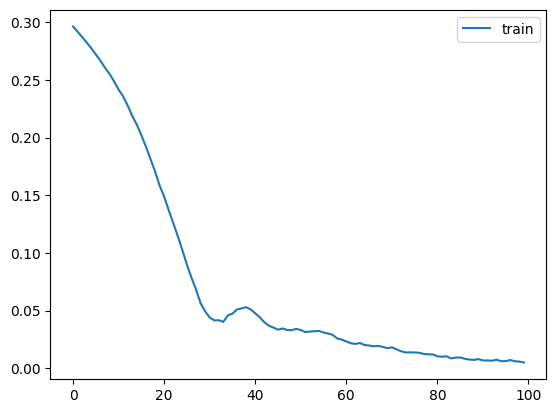

1/1 [==============================] - 0s 26ms/step


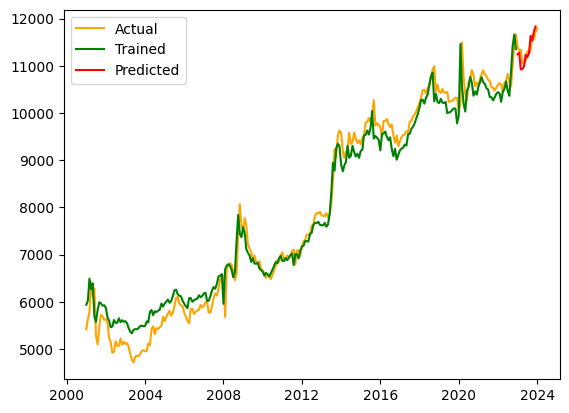

Test RMSE normal : 182.555
Test MSE normal : 33326.304


In [ ]:
  # @title Hasil model LSTM
  model_lstm = build_model_lstm(train_X)
  history = model_lstm.fit(train_X, train_y, epochs=100, batch_size=len(train_X), validation_data=(test_X, test_y),
                      verbose=2, shuffle=False)
  model_lstm.save("rnn_model_lstm.h5")
  # plot history
  plt.plot(history.history['loss'], label='train')
  plt.legend()
  plt.show()
  # plot model_lstm and train data
  y_train = model_lstm.predict(train_X)
  inv_ymodel_lstm = inverse_normdata(scaler, train_X, y_train)
  df_inv_ymodel_lstm = pd.DataFrame(inv_ymodel_lstm, index=train_y.index)
  # plot test data
  y_test = model_lstm.predict(test_X)
  inv_y_test = inverse_normdata(scaler, test_X, y_test)
  df_inv_ytest = pd.DataFrame(inv_y_test, index=test_y.index)
  plt.plot(df, color='orange', label='Actual')
  plt.plot(df_inv_ymodel_lstm, color='green', label='Trained')
  plt.plot(df_inv_ytest, color='red', label='Predicted')
  plt.legend()
  plt.show()
  # inverse data dari 0-1 menjadi range awal
  inv_test_y = inverse_normdata(scaler, test_X, test_y)
  rmse_normal = sqrt(mean_squared_error(inv_test_y, inv_y_test))
  print('Test RMSE normal : %.3f' % rmse_normal)
  print('Test MSE normal : %.3f' % mean_squared_error(inv_test_y, inv_y_test))